I've been taking a class about stochastic calculus, so in this post I want to explore some basic monte carlo simulations of Brownian Motion and two fundamental stochastic differential equations.

# Brownian Motion
---
First, we have to simulate the fundmanetal process that drives most of stochastic calculus: Brownian Motion.

> A stochastic process $W$ is Brownian Motion if the following hold:
> 1. $W_0 = 0$
> 2. $W$ has independent increments, i.e. if $r < s \le t < u$ then $W_u - W_t$ and $W_s - W_r$ are independent random variables
> 3. For $s<t$ the random variable $W_t - W_s$ is normally distributed with $\mu=0$ and $\sigma^2=t-s$
> 4. $W$ is continuous

Proving that a process like this exists is possible, but very hard, especially property 4, but we will take it as given.

So, given these properties, how do we generate sample paths? Well let's define $T$ to be the terminal time we want to simulate till and $n$ be the number of sample points we want to generate. Then we have a set of times $t_0 = 0 < t_1 < \ldots < t_{n-1} < t_n=T$ where $t_n - t_{n-1} = \frac{T}{n-1}$. So, from property (3) in the definition we know that $W_{t_n} - W_{t_{n-1}} \sim \mathcal{N}(0, \frac{T}{n-1})$. If we define a set of independent random variables $Z_r \sim \mathcal{N}(0, \frac{T}{n-1})$ then we can say that $W_{t_n} - W_{t_{n-1}} = Z_{t_n}$, or $W_{t_n} = Z_{t_n} + W_{t_{n-1}}$. Then using property (1) in the definition we get (taking liberties with the time subscript) that $W_0 = 0$ and $W_1 = Z_1 + W_0 = Z_1$, $W_2 = Z_1 + W_1 = Z + Z_2$, $W_3 = Z_3 + W_2 = Z_3 + Z_2 + Z_1$, and so on. In other words, $W_t$ is just a sum of independent normal random variables with $\mu = 0$ and $\sigma^2 = \frac{T}{n-1}$. So, to generate $n$ samples of Brownian Motion from time $t=0$ to $t=T$ we simply need to compute the cumulative sum of $n-1$ samples from a normal distribution with $\mu = 0$ and $\sigma^2 = \frac{T}{n-1}$, which is what the function below does.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 10)

rng = np.random.default_rng()


def BM_gen(T, n):
    # Variance scales with difference in time between each sample point
    # dividing by (n-1) because of fencepost-counting
    sigma_sq = T / (n - 1)
    t = np.linspace(0, T, n)
    norm_sample = rng.normal(0, np.sqrt(sigma_sq), n - 1)
    # Brownian motion assumed to start at 0 at time t=0
    W_t = np.append([0], norm_sample.cumsum())
    return (t, W_t)

And then we can simulate a few sample paths and plot them. Note that $T=2$ and $n=1000$. As $n \rightarrow \infty$ the sample path converges to true continous Brownian Motion, these are all discrete approximations.

Text(0, 0.5, 'Value')

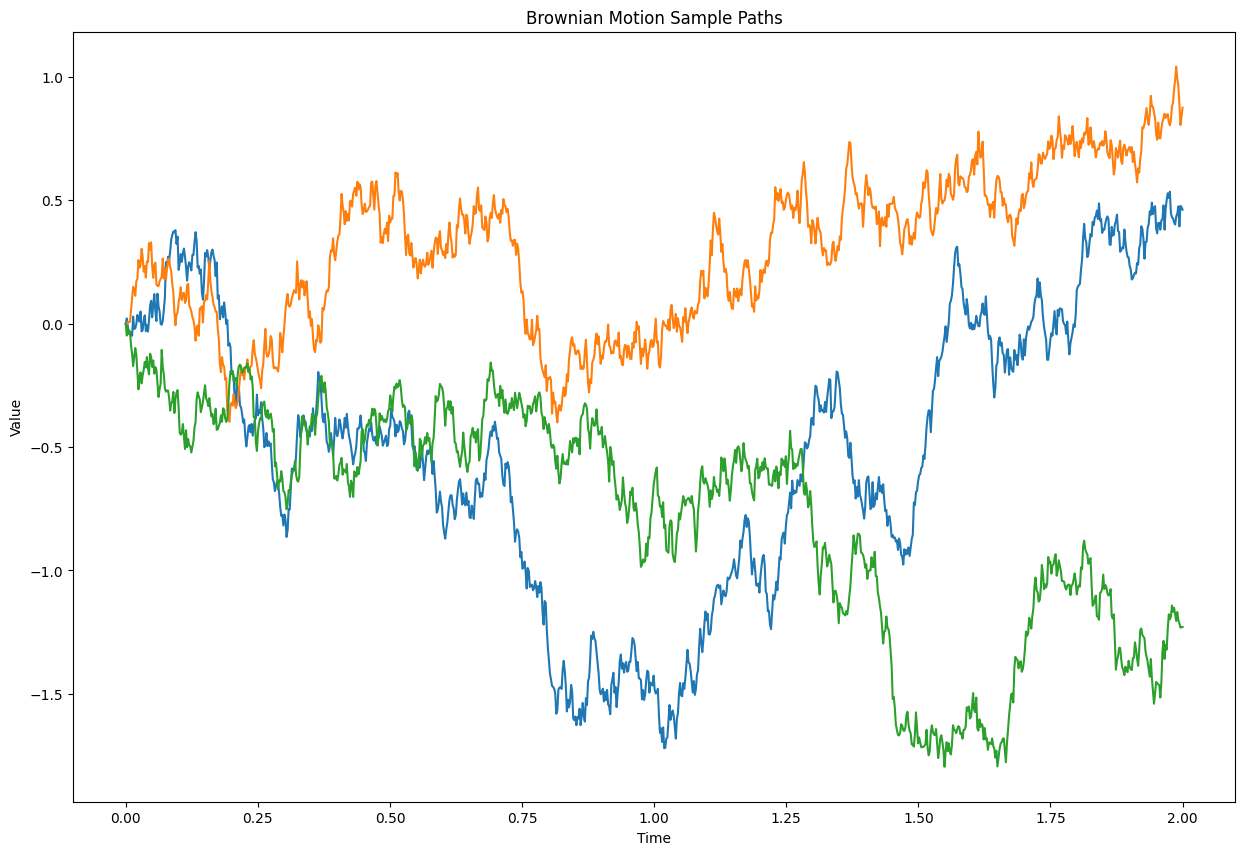

In [25]:
t, bm = BM_gen(2, 1000)
_, bm2 = BM_gen(2, 1000)
_, bm3 = BM_gen(2, 1000)
plt.plot(t, bm)
plt.plot(t, bm2)
plt.plot(t, bm3)
plt.title("Brownian Motion Sample Paths")
plt.xlabel("Time")
plt.ylabel("Value")

# Geometric Brownian Motion
---
Now we move on to what is probably the most widely applied stochastic process: Geometric Brownian Motion
> Geometric Brownian motion is the process that satisfies the following stochastic differential equation:
> $ dX_t = \mu X_t dt + \sigma X_t dW_t \\ X_0 = x_0$

Using methods of stochastic calculus, one can arrive at the following solution:
> $ X_t = x_0 \exp((\mu - \frac{\sigma^2}{2}) t + \sigma W_t) $. 

Which has expectation
>$E[X_t] = x_0 e^{\mu t}$

Note one important property of this solution is that it always has the same sign as the initial condition. This makes it useful for modelling stock prices as they need to be always positive.

Because of this simple formula, it's very easy to simulate sample paths of Geometric Brownian Motion once you have a Brownian Motion sample path:

In [26]:
def GBM_gen(x_0, mu, sigma, T, n):
    t, W_t = BM_gen(T, n)
    X_t = x_0 * np.exp((mu - sigma**2 / 2) * t + sigma * W_t)
    return (t, X_t)

And then we can again generate some sample paths and plot the expected value function:

Text(0, 0.5, 'Value')

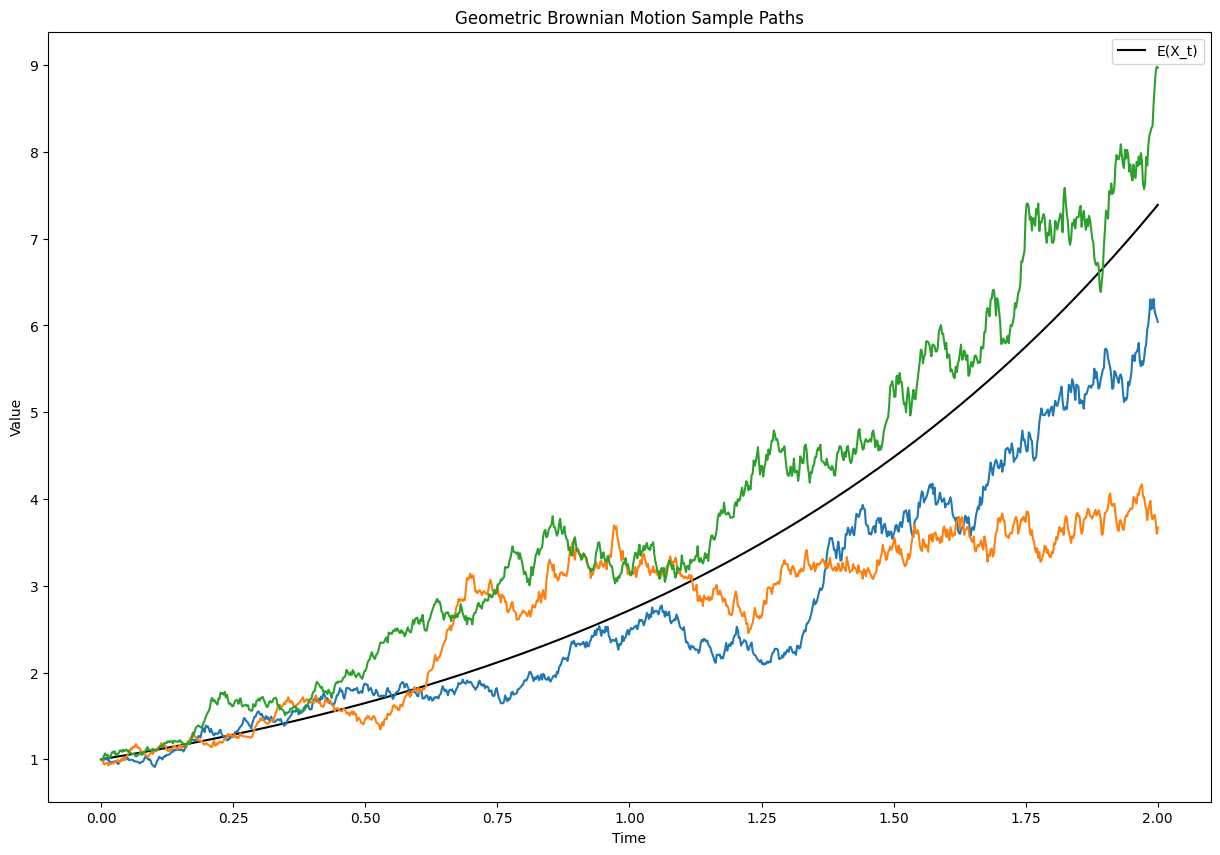

In [39]:
x_0 = 1
mu = 1
sigma = 0.4
t, gbm = GBM_gen(x_0, mu, sigma, 2, 1000)
_, gbm2 = GBM_gen(x_0, mu, sigma, 2, 1000)
_, gbm3 = GBM_gen(x_0, mu, sigma, 2, 1000)

plt.plot(t, x_0 * np.exp(mu * t), color="black")
plt.plot(t, gbm)
plt.plot(t, gbm2)
plt.plot(t, gbm3)
plt.legend(["E(X_t)"])
plt.title("Geometric Brownian Motion Sample Paths")
plt.xlabel("Time")
plt.ylabel("Value")

# The Linear Stochastic Differential Equation
---
Next is the Linear SDE:
> $dX_t = \mu X_t dt + \sigma dW_t \\ X_0 = x_0$

This has the same drift term as GBM, but doesn't scale it's noise by the current value of the process. This has solution
> $ X_t = x_0 e^{\mu t} + \sigma \int_{0}^{t} e^{\mu(t-s)} dW_s $

With expectation
> $E[X_t] = x_0e^{\mu t} $

which we expect given the matching drift term to GBM.

This, unlike the GBM solution, includes a stochastic integral which must be estimated. In a similar vein to traditional Riemann–Stieltjes integrals, we can estimate stochastic integrals by
> $ \int_{a}^{b} g_s dW_s = \sum_{k=0}^{n-1} g_{t_k}(W_{t_{k+1}} - W_{t_k}) $

where $g$ is some arbitrary function or process and each $t_k$ is a time partition like we defined in the section above on Brownian Motion. As $n \rightarrow \infty$ this sum converges to the integral. The function below estimates this sum given a function, a set of times, and a Brownian Motion sample path:

In [40]:
def stoch_int_est(g, t, W_t):
    # W_(t+1) - W_t
    # Duplicate last difference so that the length of this vector matches t
    # This is not technically correct, but is good enough
    forward_diff = np.append(W_t[1:] - W_t[:-1], W_t[-1] - W_t[-2])
    func_vals = g(t, t[-1])
    return (func_vals * forward_diff).cumsum()

We can test that this function works by estimating a stochastic integral we know the solution to. The integral of Brownian Motion with respect to itself
> $ \int_{0}^{t} W_s dW_s $

can be shown using Ito's Lemma to have the solution
> $\frac{W_t^2 - t}{2}$

Below, we plot a Brownian Motion sample path, the known solution of the integral of that path with respect to itself, and the estimate given by the above function:

Text(0, 0.5, 'Value')

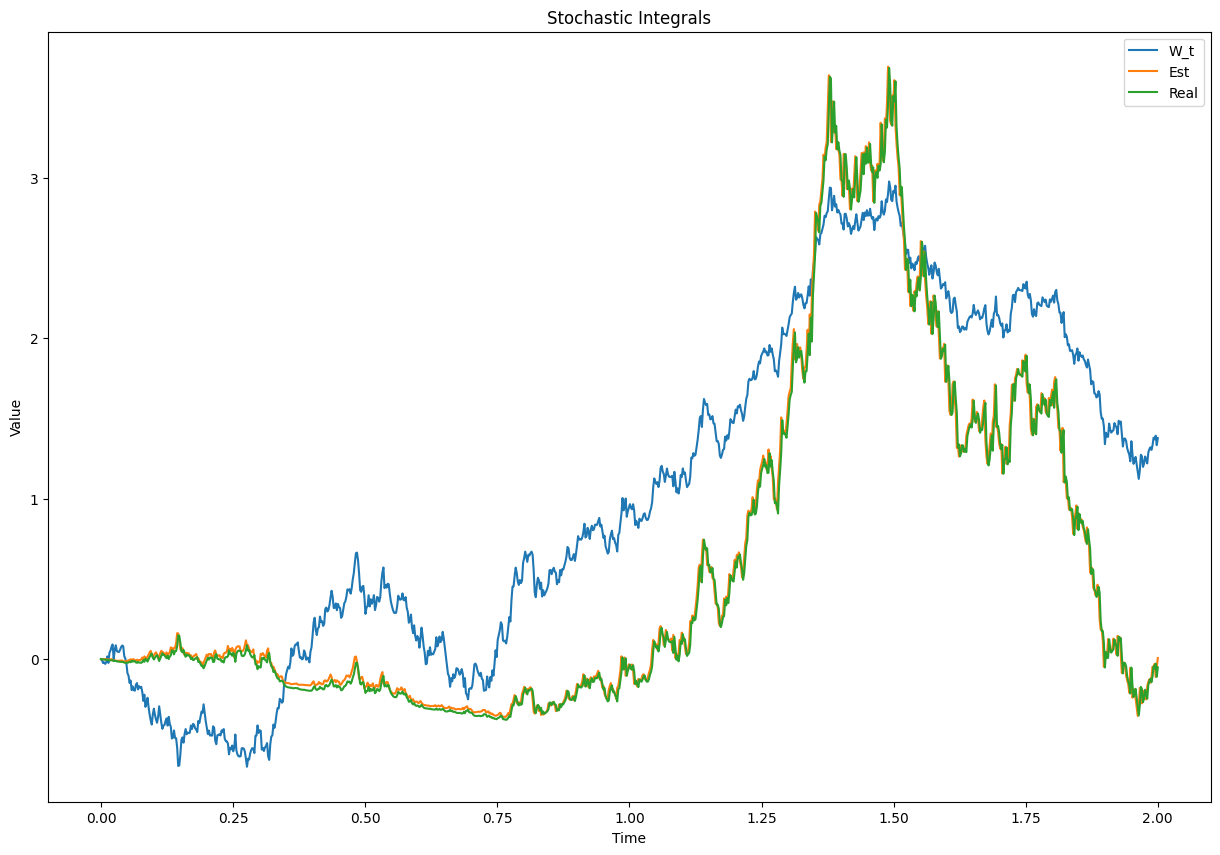

In [46]:
t, W_t = BM_gen(2, 1000)
plt.plot(t, W_t)
plt.plot(t, stoch_int_est(lambda s, t: W_t, t, W_t))
plt.plot(t, (W_t**2 - t) / 2)
plt.legend(["W_t", "Est", "Real"])
plt.title("Stochastic Integrals")
plt.xlabel("Time")
plt.ylabel("Value")

You can see the estimate and the real solutions are quite close to each other, verifying the behavior of our estimation function. As we set $n$ to larger values, the convergence will improve. Now, we can use our estimate of the stochastic integral to create sample paths of the linear SDE:

In [2]:
def linear_sde_gen(x_0, mu, sigma, T, n):
    t, W_t = BM_gen(T, n)
    X_t = x_0 * np.exp(mu * t) + sigma * stoch_int_est(
        lambda s, t: np.exp(mu * (t - s)), t, W_t
    )
    return t, X_t

And again we can simulate some sample paths along with their expectation:

Text(0, 0.5, 'Value')

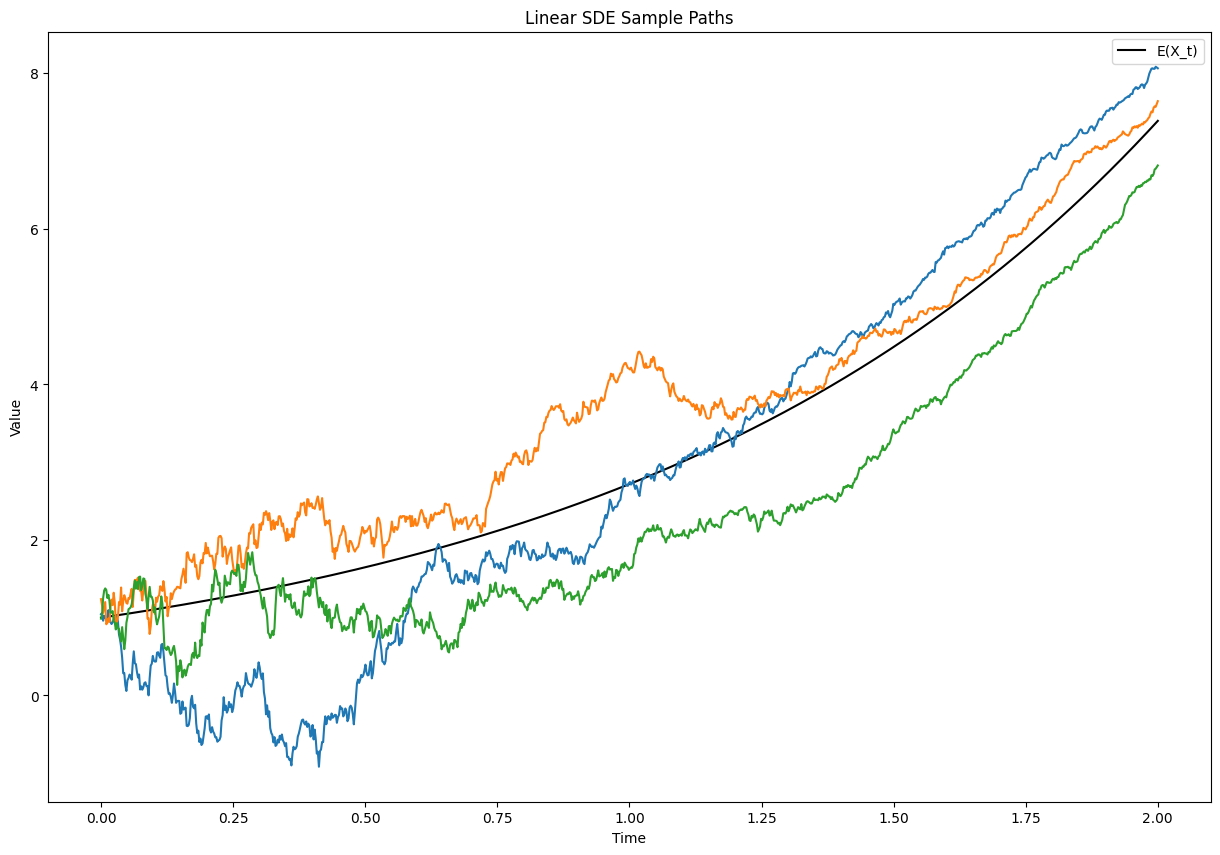

In [51]:
x_0 = 1
mu = 1
sigma = 0.4
t, linear_sde = linear_sde_gen(x_0, mu, sigma, 2, 1000)
_, linear_sde2 = linear_sde_gen(x_0, mu, sigma, 2, 1000)
_, linear_sde3 = linear_sde_gen(x_0, mu, sigma, 2, 1000)

plt.plot(t, x_0 * np.exp(mu * t), color="black")
plt.plot(t, linear_sde)
plt.plot(t, linear_sde2)
plt.plot(t, linear_sde3)
plt.legend(["E(X_t)"])
plt.title("Linear SDE Sample Paths")
plt.xlabel("Time")
plt.ylabel("Value")

As compared to GBM, we can see that firstly, the values can become negative even with a positive initial condition. Secondly, because the noise doesn't scale with the value of the process, we can see that the noise becomes smaller as time increases.

# Conclusion
---
This was a basic introduction to simulation of stochastic processes along with an example of how to estimate stochastic integrals.

# References
---
> Björk, T. (2020). Arbitrage theory in continuous time. Oxford University Press. 